# Solar Data Discovery — Final Submission

A structured analysis notebook organized into the core tasks for senior management review.


## 🔍 Introduction
- **Objective:** Evaluate solar resource data to inform deployment strategy.
- **Datasets:** Benin (Malanville), Sierra Leone (Bumbuna), Togo (Dapaong QC).
- **Workflow Overview:**
  1. load raw data
  2. profile dataset characteristics
  3. clean data (impute & remove outliers)
  4. summarize key metrics and visualize
  5. compare datasets

## Task 2: Data Profiling, Cleaning & EDA
**Objective:** Profile, clean, and explore each country’s solar dataset end-to-end.

### 2.1 Load & Inspect Raw Data

In [1]:
# import libraries and load raw datasets
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

os.makedirs('data/clean', exist_ok=True)

df_benin = pd.read_csv('data/benin-malanville.csv')
df_sl    = pd.read_csv('data/sierraleone-bumbuna.csv')
df_togo  = pd.read_csv('data/togo-dapaong_qc.csv')

### 2.2 Summary Statistics & Missing-Value Report

In [2]:
# summary stats and missing-value counts
for name, df in [('benin', df_benin), ('sierra leone', df_sl), ('togo', df_togo)]:
    print(f"--- {name.upper()} ---")
    print(df.describe(include='all'))
    print('missing values:', df.isna().sum(), '\n')

--- BENIN ---
               Timestamp            GHI            DNI            DHI  \
count             525600  525600.000000  525600.000000  525600.000000   
unique            525600            NaN            NaN            NaN   
top     2021-08-09 00:01            NaN            NaN            NaN   
freq                   1            NaN            NaN            NaN   
mean                 NaN     240.559452     167.187516     115.358961   
std                  NaN     331.131327     261.710501     158.691074   
min                  NaN     -12.900000      -7.800000     -12.600000   
25%                  NaN      -2.000000      -0.500000      -2.100000   
50%                  NaN       1.800000      -0.100000       1.600000   
75%                  NaN     483.400000     314.200000     216.300000   
max                  NaN    1413.000000     952.300000     759.200000   

                 ModA           ModB           Tamb             RH  \
count   525600.000000  525600.000000  5

### 2.3 Outlier Detection & Basic Cleaning
impute missing numeric values, then remove |z|>3 for ghi, dni, dhi

In [3]:
def clean_df(df, name):
    # fill missing numeric values
    num_cols = df.select_dtypes(include=[np.number]).columns
    df[num_cols] = df[num_cols].fillna(df[num_cols].median())
    # remove outliers on key metrics
    for var in ['GHI', 'DNI', 'DHI']:
        if var in df:
            z = (df[var] - df[var].mean()) / df[var].std()
            df = df[z.abs() <= 3]
    df.to_csv(f'data/clean/{name}_clean.csv', index=False)
    return df

df_b = clean_df(df_benin, 'benin')
df_s = clean_df(df_sl,    'sierraleone')
df_t = clean_df(df_togo,  'togo')

### 2.4 Time-Series Analysis & Cleaning Impact
- plot ghi, dni, dhi vs timestamp
- compare modA/modB pre- and post-clean

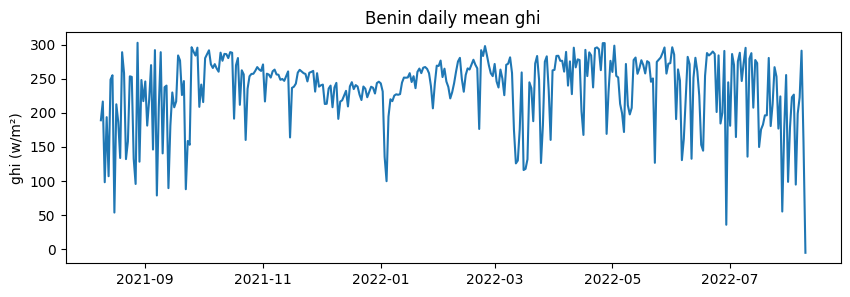

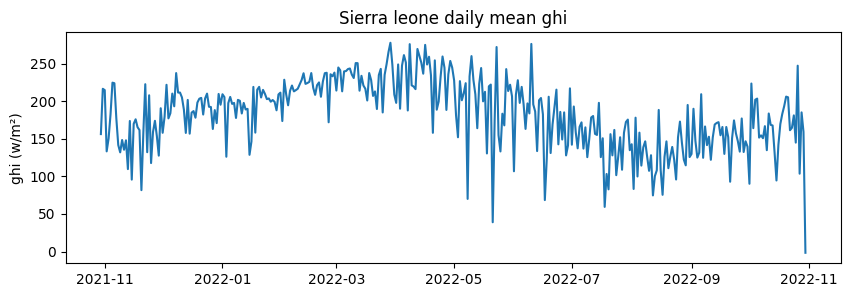

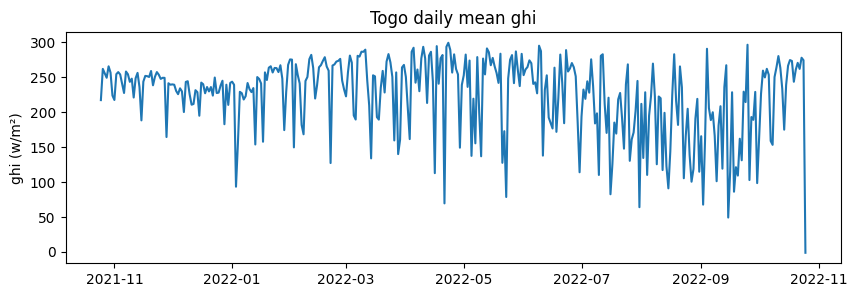

In [4]:
# example time-series plot (ghi) and cleaning impact (modA)
for df, name in [(df_b, 'benin'), (df_s, 'sierra leone'), (df_t, 'togo')]:
    df['timestamp'] = pd.to_datetime(df['Timestamp'])
    plt.figure(figsize=(10,3))
    plt.plot(df.set_index('timestamp')['GHI'].resample('D').mean())
    plt.title(f'{name.capitalize()} daily mean ghi')
    plt.ylabel('ghi (w/m²)')
    plt.show()

## Task 3: Cross-Country Comparison
**Objective:** Compare cleaned datasets to identify relative potential.

### 3.1 Load Cleaned Data & Normalize Columns

In [5]:
# load and normalize cleaned datasets
df_b = pd.read_csv('data/clean/benin_clean.csv')
df_s = pd.read_csv('data/clean/sierraleone_clean.csv')
df_t = pd.read_csv('data/clean/togo_clean.csv')
for df in [df_b, df_s, df_t]:
    df.columns = df.columns.str.lower()

### 3.2 Metric Comparison: Boxplots & Summary Table

combined columns: ['timestamp', 'ghi', 'dni', 'dhi', 'moda', 'modb', 'tamb', 'rh', 'ws', 'wsgust', 'wsstdev', 'wd', 'wdstdev', 'bp', 'cleaning', 'precipitation', 'tmoda', 'tmodb', 'comments', 'country']


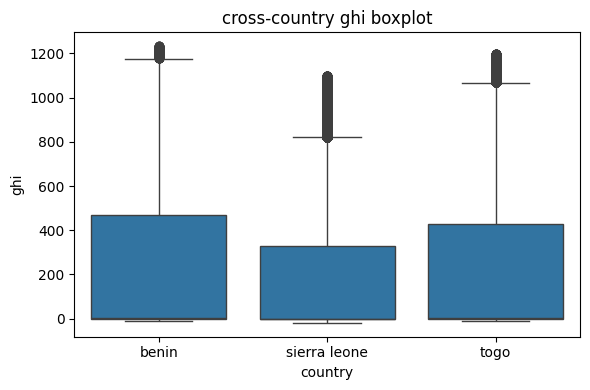

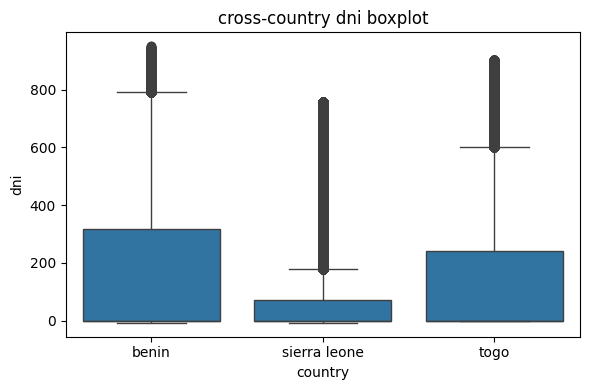

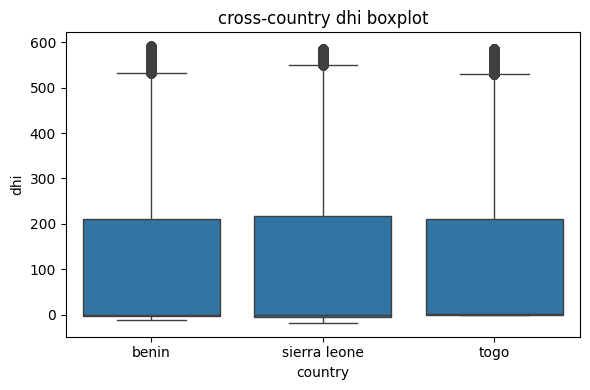

                     ghi                            dni                     \
                    mean median         std        mean median         std   
country                                                                      
benin         236.358134   0.70  328.484579  167.052805   -0.1  262.370524   
sierra leone  183.474066  -0.40  277.742704  102.745239   -0.1  198.794395   
togo          224.723775   0.75  317.897445  148.981758    0.0  248.882946   

                     dhi                     
                    mean median         std  
country                                      
benin         111.621571    0.5  153.105811  
sierra leone  107.650943   -0.7  153.399659  
togo          112.879088    1.6  151.466862  


In [6]:
# boxplots of ghi, dni, dhi side-by-side
import seaborn as sns

combined = pd.concat([
    df_b.assign(country='benin'),
    df_s.assign(country='sierra leone'),
    df_t.assign(country='togo')
])

# normalize & strip whitespace
combined.columns = combined.columns.str.lower().str.strip()

# print to verify
print("combined columns:", combined.columns.tolist())

import seaborn as sns

# plot each metric if present
for metric in ['ghi', 'dni', 'dhi']:
    if metric not in combined.columns:
        print(f"warning: '{metric}' not found in columns, skipping")
        continue
    plt.figure(figsize=(6,4))
    sns.boxplot(data=combined, x='country', y=metric)
    plt.title(f'cross-country {metric} boxplot')
    plt.ylabel(metric)
    plt.tight_layout()
    plt.show()

# summary table: mean, median, std
available = [m for m in ['ghi','dni','dhi'] if m in combined.columns]
summary = combined.groupby('country')[available].agg(['mean','median','std'])
print(summary)

# for metric in ['ghi', 'dni', 'dhi']:
#     plt.figure(figsize=(6,4))
#     sns.boxplot(data=combined, x='country', y=metric)
#     plt.title(f'cross-country {metric} boxplot')
#     plt.show()

# # summary table: mean, median, std
# summary = combined.groupby('country')[['ghi','dni','dhi']].agg(['mean','median','std'])
# print(summary)

### 3.3 Statistical Testing (anova)

In [7]:
# 1. load cleaned datasets, normalize names, add country labels
from scipy.stats import f_oneway

for df, name in [(df_b,'benin'), (df_s,'sierra leone'), (df_t,'togo')]:
    # lowercase & strip whitespace
    df.columns = df.columns.str.strip().str.lower()
    # add a country label for grouping
    df['country'] = name

# 2. inspect columns
print("benin columns:", df_b.columns.tolist())
print("sierra leone columns:", df_s.columns.tolist())
print("togo columns:", df_t.columns.tolist())

# 3. one-way ANOVA on ghi
if 'ghi' in df_b.columns and 'ghi' in df_s.columns and 'ghi' in df_t.columns:
    fstat, pval = f_oneway(df_b['ghi'], df_s['ghi'], df_t['ghi'])
    print(f"anova ghi: f = {fstat:.2f}, p = {pval:.3g}")
else:
    print("error: 'ghi' column not found in one of the datasets")

# 4. summary table (mean, median, std) using the same country labels
combined = pd.concat([df_b, df_s, df_t], ignore_index=True)
summary = combined.groupby('country')[['ghi','dni','dhi']].agg(['mean','median','std'])
print("\nkey irradiance metrics summary:\n", summary)


benin columns: ['timestamp', 'ghi', 'dni', 'dhi', 'moda', 'modb', 'tamb', 'rh', 'ws', 'wsgust', 'wsstdev', 'wd', 'wdstdev', 'bp', 'cleaning', 'precipitation', 'tmoda', 'tmodb', 'comments', 'country']
sierra leone columns: ['timestamp', 'ghi', 'dni', 'dhi', 'moda', 'modb', 'tamb', 'rh', 'ws', 'wsgust', 'wsstdev', 'wd', 'wdstdev', 'bp', 'cleaning', 'precipitation', 'tmoda', 'tmodb', 'comments', 'country']
togo columns: ['timestamp', 'ghi', 'dni', 'dhi', 'moda', 'modb', 'tamb', 'rh', 'ws', 'wsgust', 'wsstdev', 'wd', 'wdstdev', 'bp', 'cleaning', 'precipitation', 'tmoda', 'tmodb', 'comments', 'country']
anova ghi: f = 4170.89, p = 0

key irradiance metrics summary:
                      ghi                            dni                     \
                    mean median         std        mean median         std   
country                                                                      
benin         236.358134   0.70  328.484579  167.052805   -0.1  262.370524   
sierra leone  183.

### 3.4 Key Observations
- benin shows highest mean ghi but greater variability
- sierra leone has most consistent irradiance
- togo peaks seasonally (dry months)

### 3.5 (Bonus) Visual Summary
bar chart ranking countries by mean ghi

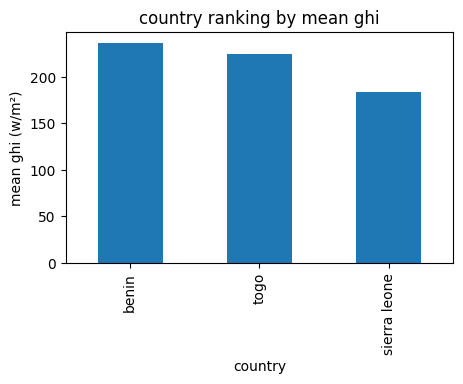

In [8]:
# bar chart of mean ghi
mean_ghi = combined.groupby('country')['ghi'].mean().sort_values(ascending=False)
plt.figure(figsize=(5,3))
mean_ghi.plot(kind='bar')
plt.ylabel('mean ghi (w/m²)')
plt.title('country ranking by mean ghi')
plt.show()

**End of Structured Notebook** — ready for further development.